In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [4]:
sample_info = pd.read_csv('~/Google Drive/Research Projects/Finished/LysisBuffers/data_exchange/lysis-buffer-samples.csv', index_col=0)
counts = pd.read_csv('~/Google Drive/Research Projects/Finished/LysisBuffers/data_exchange/lysis-buffer-counts.csv', index_col=0)

In [25]:
counts = counts.pipe(np.round).astype(int)

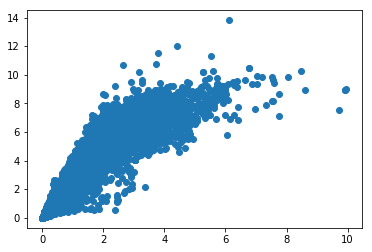

In [31]:
plt.scatter(counts.pipe(np.log1p).mean(1), counts.pipe(np.log1p).var(1));

In [34]:
idx = counts.pipe(np.log1p).var(1).sort_values(ascending=False).head(100).index

In [35]:
import patsy

Y = patsy.dmatrix('np.log1p(MT_content) + percent_mapped + sample_type + LB_type', sample_info, return_type='dataframe')
y = np.asarray(Y)

In [38]:
hv_counts = counts.loc[idx]

In [57]:
long_data = pd.melt(hv_counts.T.join(Y), id_vars=Y.columns.tolist()).dropna()
covars = long_data.drop(['variable', 'value'], 1)
genes = long_data.variable.astype('category')
y = long_data.value.values

In [78]:
import pickle

with open('zinb-wave.pkl', 'rb') as fh:
    model = pickle.load(fh)

In [79]:
N = y.shape[0]
P = covars.shape[1]
G = genes.cat.categories.shape[0]
data = {
    'N': N,
    'P': P,
    'G': G,
    'x': covars.values,
    'y': y,
    'gene': genes.cat.codes.values + 1
}

In [80]:
v = model.vb(data=data)

RuntimeError: Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.



Initialization between (-2, 2) failed after 100 attempts. 
 Try specifying initial values, reducing ranges of constrained values, or reparameterizing the model.
